In [1]:
#CNNs in page 403 of the book

In [2]:
from fastai.data.all import *
from fastai.vision.all import *

In [63]:
from PIL import Image

In [3]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path

Path('C:/Users/alex/.fastai/data/mnist_sample')

In [70]:
path2 = untar_data(URLs.PETS)/"images"

In [81]:
path2.ls

<bound method Path.ls of Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images')>

In [71]:
items = get_image_files(path2)

In [72]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

In [73]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

In [78]:
items

(#7390) [Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/alex/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

<AxesSubplot:>

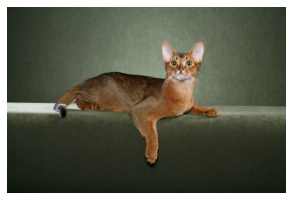

In [85]:
im2 = Image.open(path2/'Abyssinian_1.jpg')
show_image(im2)

<AxesSubplot:>

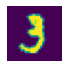

In [6]:
im1 = Image.open(path/'train'/'3'/'10.png')
show_image(im1)

In [7]:
#let's put im3 into tensor form
im1_tensor = tensor(im1)

In [8]:
#Let's make a top edge kernel with a 3x3 matrix
top_edge = tensor([[1,1,1], 
                   [0,0,0],
                   [-1,-1,-1]]).float()
im1_tensor[0:3,0:3] * top_edge  

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [-0., -0., -0.]])

In [9]:
(im1_tensor[0:3,0:3] * top_edge).sum()

tensor(0.)

In [10]:
df = pd.DataFrame(im1_tensor[:10,:20])
df.style.set_properties(**{'font-size': '10pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0
5,0,0,0,0,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0
6,0,0,0,0,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0
7,0,0,0,0,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0
8,0,0,0,0,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0
9,0,0,0,0,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0


In [11]:
(im1_tensor[4:7,10:13] * top_edge).sum()

tensor(-344.)

In [12]:
(im1_tensor[6:9,15:18] * top_edge).sum()

tensor(-16.)

In [13]:
#We can create a function to apply the kernel to any row or column so we don't have to do it manually anymore
def apply_kernel(row, col, kernel):
    return (im1_tensor[row-1:row+2,col-1:col+2] *kernel).sum()

In [14]:
apply_kernel(5,7,top_edge)

tensor(0.)

In [15]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<AxesSubplot:>

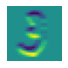

In [16]:
rnge = range(1,27)
top_edge_three = tensor([[apply_kernel(i,j,top_edge) for j in rnge] for i in rnge])
show_image(top_edge_three)

<AxesSubplot:>

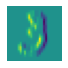

In [17]:
right_edges = tensor([
    [-1,1,0],
    [-1,1,0],
    [-1,1,0]]).float()

right = tensor([[apply_kernel(i,j,right_edges) for j in rnge] for i in rnge])

show_image(right)

<AxesSubplot:>

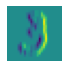

In [18]:
left_edges = tensor([
    [1,-1,0],
    [1,-1,0],
    [1,-1,0]]).float()

left = tensor([[apply_kernel(i,j,left_edges) for j in rnge] for i in rnge])

show_image(left)

In [19]:
diag1 = tensor([
    [0,-1,1],
    [-1,1,0],
    [1,0,0]]).float()

diag2 = tensor([
    [1,-1,0],
    [0,1,-1],
    [0,0,1]]).float()

In [20]:
edge_kernel = torch.stack([left_edges, top_edge, diag1, diag2])

In [21]:
edge_kernel.shape

torch.Size([4, 3, 3])

In [27]:
#test edge_kernel
test_data = DataBlock((ImageBlock(cls= PILImageBW), CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(),
                       get_y = parent_label) 

dls = test_data.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


torch.Size([64, 1, 28, 28])

In [28]:
#Fast.ai DataBlock puts data on the GPU by default but we can move it to the CPU
xb,yb = to_cpu(xb), to_cpu(yb)

In [30]:
edge_kernel.shape, edge_kernel.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [43]:
#now we can pass this all to Pytorch conv2d class
edge_kernel = edge_kernel.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernel)
batch_features.shape

RuntimeError: expected stride to be a single integer value or a list of 5 values to match the convolution dimensions, but got stride=[1, 1]

<AxesSubplot:>

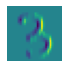

In [42]:
show_image(batch_features[0,0])

In [45]:
starting_cnn= sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1,kernel_size=3, padding=1)
)

In [46]:
starting_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [47]:
#we don't want an output of 28x28 activations so we need enough stride2 convs to get us down to 1 act per image
def conv(num_in, num_feat, kernel_size=3, act=True):
    res = nn.Conv2d(num_in, num_feat, stride=2, kernel_size=kernel_size, padding= kernel_size//2)
    if act: res = nn.Sequential(res,nn.ReLU())
    return res

In [51]:
simple_conv = sequential(
    conv(1,4),   #14x14 output
    conv(4,8),   #7x7 output
    conv(8,16),  #4x4 output
    conv(16,32), #2x2 output
    conv(32,2, act=False), #1x1 output
    Flatten(),
)

simple_conv(xb).shape

torch.Size([64, 2])

In [52]:
#now we can create a learner (Fast.ai specific)

learner = Learner(dls, simple_conv, loss_func= F.cross_entropy, metrics=accuracy)

learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [53]:
learner.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.063214,0.039318,0.990677,00:54
1,0.028653,0.025012,0.992149,00:15


In [55]:
m = learner.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [56]:
#Above means 1 input channel, 4 output channels,a 3x3 kernel, stride of 2 and padding of 1

In [58]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [59]:
m[0].bias.shape

torch.Size([4])

In [88]:
#extending to color
color_cat = image2tensor(im2)
color_cat.shape

torch.Size([3, 400, 600])

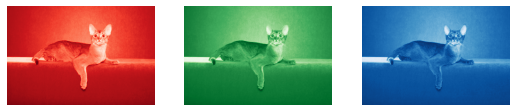

In [91]:
_, axzees = subplots(1,3)
for cat, axis, color in zip(color_cat,axzees,('Reds','Greens', 'Blues')):
    show_image(255- cat, ax=axis, cmap=color)

In [93]:
#training using the full MNIST dataset
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('C:/Users/alex/.fastai/data/mnist_png/testing'),Path('C:/Users/alex/.fastai/data/mnist_png/training')]

In [95]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y= parent_label,
        batch_tfms = Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


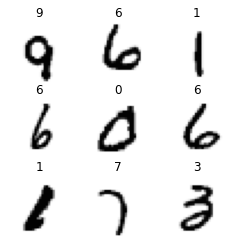

In [96]:
dls.show_batch(max_n=9, figsize=(4,4))

In [103]:
#baseline model
def base_cnn():
    return sequential(
        conv(1,8, kernel_size=5),   #14x14 output
        conv(8,16),         #7x7 output
        conv(16,32),        #4x4 output
        conv(32,64),       #2x2 output
        conv(64,10, act=False), #1x1 output
        Flatten(),
    )

In [98]:
from fastai.callback.hook import *

In [104]:
#Let's speed up training with a higher learning rate than before
def fit(epochs=1):
    learner = Learner(dls, base_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learner.fit(epochs, 0.06)
    return learner

learner = fit()

C:\Users\alex\Anaconda3\envs\fastai\lib\site-packages\fastai\callback\core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.645810,0.556859,0.821100,04:23


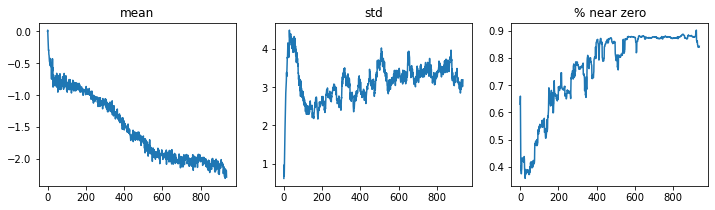

In [105]:
#let's check the stats
learner.activation_stats.plot_layer_stats(0)

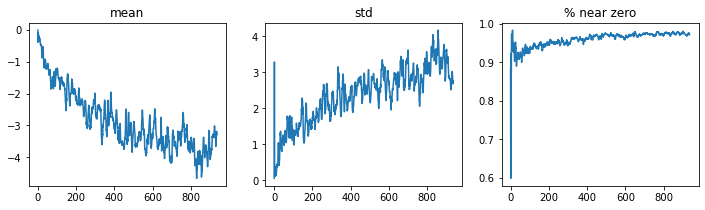

In [106]:
learner.activation_stats.plot_layer_stats(-2)

In [107]:
dls = get_dls(512)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [108]:
learner = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.309808,2.302265,0.113500,01:06


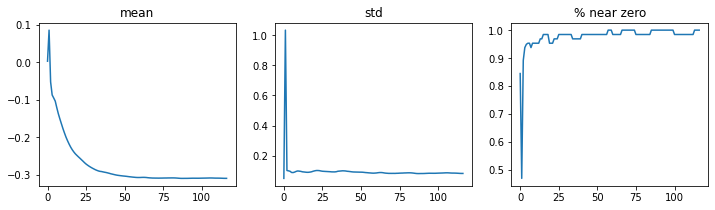

In [109]:
learner.activation_stats.plot_layer_stats(-2)

In [110]:
def fit(epochs=1, lr=0.06):
    learner = Learner(dls, base_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learner.fit_one_cycle(epochs, lr)
    return learner

In [111]:
learner = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.216626,0.081243,0.975400,01:10


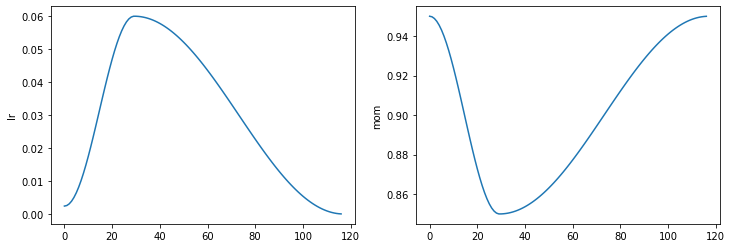

In [112]:
learner.recorder.plot_sched()

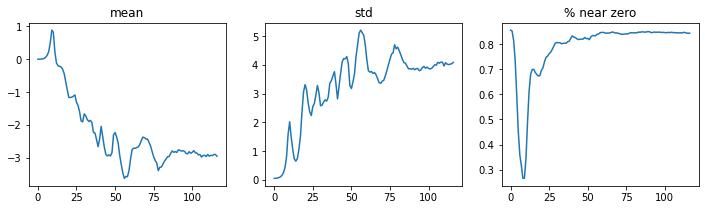

In [113]:
learner.activation_stats.plot_layer_stats(-2)

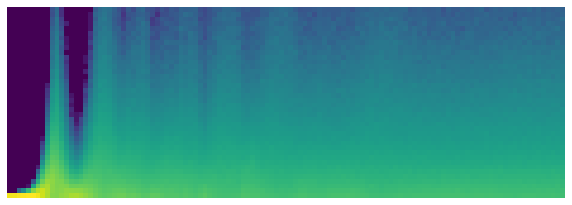

In [114]:
learner.activation_stats.color_dim(-2)

In [115]:
#add batch norm to fix all those zeros we see above in the beginning of training
def conv(num_in, num_feat, kernel_size=3, act=True):
    layers = [nn.Conv2d(num_in, num_feat, stride=2, kernel_size=kernel_size, padding=kernel_size//2)]
    layers.append(nn.BatchNorm2d(num_feat))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [116]:
learner = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.126370,0.053880,0.987400,01:10


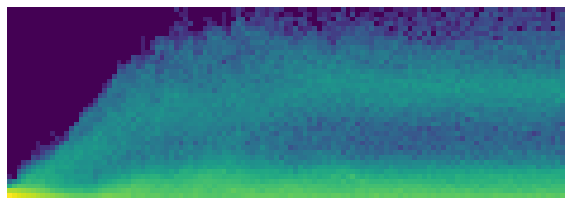

In [117]:
learner.activation_stats.color_dim(-2)

In [119]:
learner = fit(5, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.463610,0.204846,0.977800,01:12
1,0.146909,0.097504,0.980900,01:13
2,0.070598,0.056542,0.989000,01:14
3,0.040945,0.042821,0.990500,01:13
4,0.027500,0.037015,0.991200,01:09
